iteration: 0
Loss after iteration 1000: 0.021561
Loss after iteration 2000: 0.018044
Loss after iteration 3000: 0.017215
Loss after iteration 4000: 0.016804
Loss after iteration 5000: 0.016303
Loss after iteration 6000: 0.015666
Loss after iteration 7000: 0.014974
Loss after iteration 8000: 0.014247
Loss after iteration 9000: 0.013414
Loss after iteration 10000: 0.012491
iteration: 10000
Loss after iteration 11000: 0.011458
Loss after iteration 12000: 0.010234
Loss after iteration 13000: 0.008527
Loss after iteration 14000: 0.000931
[[-1.85462041 -1.43206382]
 [-1.84462041 -1.43206382]
 [-1.83462041 -1.43206382]
 ..., 
 [ 2.72537959  1.83793618]
 [ 2.73537959  1.83793618]
 [ 2.74537959  1.83793618]]


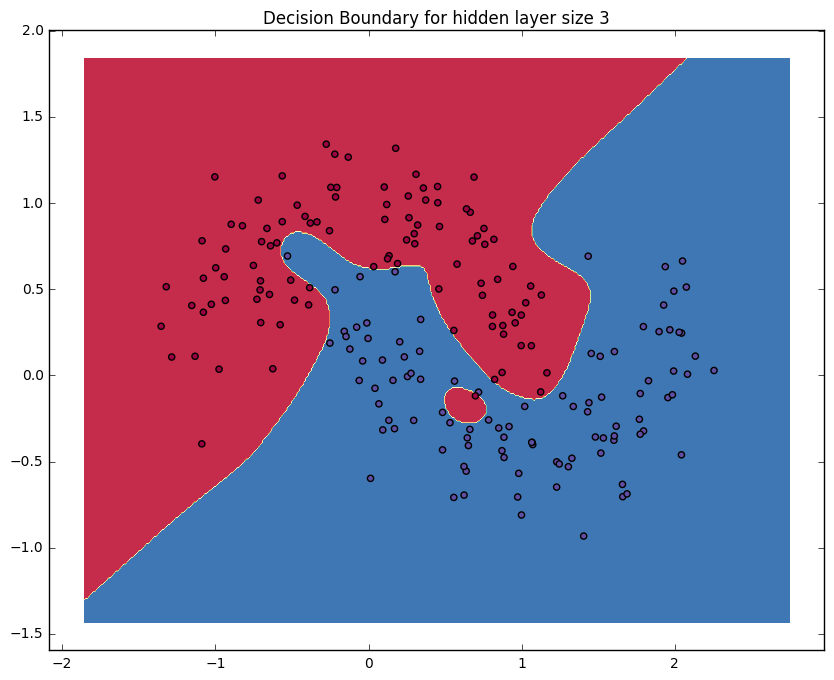

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

"""
实现具有一个隐层的2层神经网络。
绘图结果的点颜色是标签分类，分类边界是策略结果。
"""

# 绘图
def plot_decision_boundary(X, y, pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# 准备数据
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
# X的一个item是一个二维向量或者二维坐标(x1,x2), y的一个item是标量0或者1


def sigmoid(x):
    return 1/(1+np.exp(-x))

def dfn_tanh(x):
    return 1 - np.power(x, 2)

def dfn_sigmoid(x):
    return x * (1 - x)

if True:  # 貌似tanh比sig好使。据说relu更好使
    # 使用 tanh 作为激活函数
    num_examples = len(X) # 训练集数据条数
    nn_input_dim = 2 # 输入维数
    nn_output_dim = 2 # 输出维数
    epsilon = 0.02 # 梯度下降学习率
    reg_lambda = 0.001 # 标准化强度。就是把参数拉着不让它更新
    dfn = dfn_tanh
    activation_fn = np.tanh
else:
    # 使用 sigmoid 作为激活函数
    num_examples = len(X) # 训练集数据条数
    nn_input_dim = 2 # 输入维数
    nn_output_dim = 2 # 输出维数
    epsilon = 0.01 # 梯度下降学习率
    reg_lambda = 0.01 # 标准化强度
    dfn = dfn_sigmoid
    activation_fn = sigmoid

def do_work(x, model, target=None, only_predict=False):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 计算神经网络的输出
    z1 = x.dot(W1) + b1
    a1 = activation_fn(z1)
    z2 = a1.dot(W2) + b2

    # 根据softmax的公式，将数据映射到(0,1)
    exp_scores = np.exp(z2) # 将数值映射为正数，就可以不考虑负数的情况
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # 计算每个输出占据总输出的比例，作为选择该分类的概率
        # 不需要每个分类的概率时，也可以直接返回 np.argmax(exp_scores, axis=1)
    
    if not only_predict:
        # BP反向传播计算delta
        delta3 = probs
        
        # dw的推到详见：http://www.mamicode.com/info-detail-671452.html

        delta3[range(num_examples), target] -= 1  # 对z2求偏导的结果
        dW2 = (a1.T).dot(delta3)  # 对w2求偏导的结果
        db2 = np.sum(delta3, axis=0, keepdims=True)
        
        delta2 = delta3.dot(W2.T) * dfn(a1)  # 对z1求偏导的结果
        dW1 = np.dot(X.T, delta2)  # 对w1求偏导的结果
        db1 = np.sum(delta2, axis=0)
        
        # 用目前的值做校正
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # 用delta更新参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        model.update({ 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2})
    return probs

def calculate_loss(X, y, model):
    # 计算神经网络输出
    probs = do_work(X, model, only_predict=True)
    # 计算与标签值的误差
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    corect_logprobs = -np.log(probs[range(num_examples), y]) # 把标签值对应的预测概率选出来。这些值在 (0,1) 之间。
        # 计算 -log 值，将 (0,1) 映射到 (INF,0)。如果误差小，则选出来的值应该接近 1，-log 之后应该接近 0
    data_loss = np.sum(corect_logprobs) # 所以算出来的 sum 也应该接近 0
    # data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./ num_examples * data_loss # 每条训练数据的平均误差

# Helper function to predict an output (0 or 1)
def predict(model, x):
    # 计算每个分类的概率
    probs = do_work(x, model, only_predict=True)
    # 返回概率最大的那个分类
    return np.argmax(probs, axis=1) # np里面的操作默认是按列进行（axis=0），axis=1表示按行进行

def build_model(X, y, nn_hdim):
    # 使用随机值来创建初始神经网络
    import time
    np.random.seed(19930928)
    init_x = 0
    init_y = 1
    W1 = np.random.uniform(init_x, init_y, (nn_input_dim,nn_hdim))
    b1 = np.random.uniform(init_x, init_y, (1,nn_hdim))
    W2 = np.random.uniform(init_x, init_y, (nn_hdim,nn_output_dim))
    b2 = np.random.uniform(init_x, init_y, (1,nn_output_dim))
    
    # 保存神经网络的最终结果
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # BP方式来更新神经网络
    last_loss = 1
    for i in range(300000):
        # 更新模型
        do_work(X, model, target=y, only_predict=False)
        # 误差已经足够小了就退出
        if i % 1000 == 0:
            loss = calculate_loss(X, y, model)
            if loss - last_loss < -0.0001:
                print "Loss after iteration %i: %f" %(i, loss)
                last_loss = loss
            if loss < 0.02:  # loss足够小的时候降低一点学习率，更精细地训练
                epsilon = 0.008
            if loss < 0.006: # 目标loss是0.01时，基本上二分之后就是100%准确地过拟合了
                break
        if i % 10000 == 0:
            print 'iteration: %s' % i
    return model

# 使用三个神经元的隐含层
model = build_model(X, y, 250)  # 按理说更高就更容易过拟合。但是高了跑起来太慢了

# 绘图
def pred(x):
    print x
    return predict(model, x)
plot_decision_boundary(X, y, pred)
plt.title("Decision Boundary for hidden layer size 3")